[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lweitkamp/GANs-JAX/blob/main/3_Conditional_GANs.ipynb)


# Conditional GANs

This notebook is based on the paper <a href="https://arxiv.org/pdf/1411.1784.pdf">Conditional Generative Adversarial Nets</a>. In my mind, it is a completely natural follow up to the original GAN paper: we know the method works on unlabeled data, what if we can actually make use of labels to create a more informed latent space? The Conditional GAN treats the labels as observed variables, and conditions the data $x$ on the label $y$. We now utilize this information in the minimax game:



$$
\large{
  \min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x|y)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z | y)))]
}
$$

Here, the generator takes as input the noise $z$ and label $y$ to generate the output $x$. The discriminator takes as input the output $x$ and label $y$, and outputs a real/fake classsification.

In [1]:
# Get the latest JAX, jaxlib and Flax
# !pip install --upgrade -q jax jaxlib
!pip install --upgrade -q flax

import jax
import flax

import jax.numpy as jnp
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from IPython.display import clear_output
from jax.nn.initializers import normal as normal_init
from flax import linen as nn

     |████████████████████████████████| 184kB 21.3MB/s 


### Loading MNIST

In [2]:
def set_range(batch):
  batch, labels = batch['image'], batch['label']  #  We now add the labels to the generator.
  batch = tf.image.convert_image_dtype(batch, tf.float32)
  batch = (batch - 0.5) / 0.5  # tanh range is -1, 1
  return (batch, labels)
 

mnist_data = tfds.load("mnist")['train']
batches_in_epoch = len(mnist_data) // 128
 
data_gen = iter(tfds.as_numpy(
      mnist_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_data), seed=42)
        .repeat()
        .batch(128)
 ))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Flax Linen Architecture

In [3]:
class Generator(nn.Module):
  features: int = 64
  training: bool = True

  @nn.compact
  def __call__(self, z):
    z = z.reshape((z.shape[0], 1, 1, z.shape[1]))
    x = nn.ConvTranspose(self.features*4, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(z)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features*4, [4, 4], [1, 1], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features*2, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = jnp.tanh(x)
    return x


class Discriminator(nn.Module):
  features: int = 64
  training: bool = True

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(self.features, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Conv(self.features*2, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Conv(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = x.reshape((x.shape[0], -1))
    return x


def sample_latent(key, shape):
  return jax.random.normal(key, shape=shape)


@jax.jit
def fetch_oh_labels(labels, num_classes=10):
  oh_labels = jax.nn.one_hot(labels, num_classes=num_classes)
  oh_labels_img = oh_labels[:, None, None, :].repeat(28, 1).repeat(28, 2)
  return oh_labels, oh_labels_img

## Loss Functions

In [4]:
def bce_logits(logit, label):
  """
  Implements the BCE with logits loss, as described:
  https://github.com/pytorch/pytorch/issues/751
  """
  neg_abs = -jnp.abs(logit)
  batch_bce = jnp.maximum(logit, 0) - logit * label + jnp.log(1 + jnp.exp(neg_abs))
  return jnp.mean(batch_bce)


def loss_generator(params_g, params_d, vars_g, vars_d, data, key):
  oh_labels, oh_labels_img = fetch_oh_labels(data[1])

  latent = sample_latent(key, shape=(data[0].shape[0], 64))
  latent = jnp.concatenate([latent, oh_labels], axis=-1)

  fake_data, vars_g = Generator().apply(
      {'params': params_g, 'batch_stats': vars_g['batch_stats']},
      latent, mutable=['batch_stats']
  )

  fake_data = jnp.concatenate([fake_data, oh_labels_img], axis=-1)

  fake_preds, vars_d = Discriminator().apply(
      {'params': params_d, 'batch_stats': vars_d['batch_stats']},
      fake_data, mutable=['batch_stats']
  )

  loss = -jnp.mean(jnp.log(nn.sigmoid(fake_preds)))
  return loss, (vars_g, vars_d)


def loss_discriminator(params_d, params_g, vars_g, vars_d, data, key):
  oh_labels, oh_labels_img = fetch_oh_labels(data[1])

  latent = sample_latent(key, shape=(data[0].shape[0], 64))
  latent = jnp.concatenate([latent, oh_labels], axis=-1)

  fake_data, vars_g = Generator().apply(
      {'params': params_g, 'batch_stats': vars_g['batch_stats']},
      latent, mutable=['batch_stats']
  )

  fake_data = jnp.concatenate([fake_data, oh_labels_img], axis=-1)
  real_data = jnp.concatenate([data[0], oh_labels_img], axis=-1)

  fake_preds, vars_d = Discriminator().apply(
      {'params': params_d, 'batch_stats': vars_d['batch_stats']},
      fake_data, mutable=['batch_stats']
  )

  real_preds, vars_d = Discriminator().apply(
      {'params': params_d, 'batch_stats': vars_d['batch_stats']},
      real_data, mutable=['batch_stats']
  )

  real_loss = bce_logits(real_preds, jnp.ones((data[0].shape[0],), dtype=jnp.int32))
  fake_loss = bce_logits(fake_preds, jnp.zeros((data[0].shape[0],), dtype=jnp.int32))
  loss = (real_loss + fake_loss) / 2

  return loss, (vars_g, vars_d)

## Defining the training step

In [5]:
@jax.jit
def train_step(data, vars_g, vars_d, optim_g, optim_d, rng):
  key, key_gen, key_disc = jax.random.split(rng, 3)

  # Train the generator
  grad_fn_generator = jax.value_and_grad(loss_generator, has_aux=True)
  (loss_g, (vars_g, vars_d)), grad_g = grad_fn_generator(
      optim_g.target, optim_d.target, vars_g, vars_d, data, key_gen
  )

  optim_g = optim_g.apply_gradient(grad_g)
  
  # Train the discriminator
  grad_fn_discriminator = jax.value_and_grad(loss_discriminator, has_aux=True)
  (loss_d, (vars_g, vars_d)), grad_d = grad_fn_discriminator(
      optim_d.target, optim_g.target, vars_g, vars_d, data, key_disc
  )

  optim_d = optim_d.apply_gradient(grad_d)

  loss = {'generator': loss_g, 'discriminator': loss_d}
  return loss, vars_g, vars_d, optim_g, optim_d, key


@jax.jit
def eval_step(params, vars, latent):  
  fake_data, _ = Generator(training=False).apply(
      {'params': params, 'batch_stats': vars['batch_stats']},
      latent, mutable=['batch_stats']
  )

  return fake_data

## Training the model

In [6]:
def plot(images, loss, labels, epoch):
  clear_output(True)

  # First plot the losses.
  fig, ax = plt.subplots(figsize=(10, 4))
  ax.plot(loss['generator'], label='Generator Loss')
  ax.plot(loss['discriminator'], label='Discriminator Loss')
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  fig.suptitle(f"Epoch {epoch}")


  fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10), tight_layout=True)
  for ax, image, label in zip(sum(axes.tolist(), []), images, labels):
    ax.imshow(image[:, :, 0], cmap='gray')
    ax.set_axis_off()
    ax.text(0, 0, f"{label}", bbox=dict(facecolor='white'))

  plt.show()

In [7]:
key = jax.random.PRNGKey(seed=41)
key, key_gen, key_disc, key_latent = jax.random.split(key, 4)

# Retrieve shapes for generator and discriminator input.
latent = sample_latent(key_latent, shape=(100, 64))
labels = jnp.tile(jnp.arange(10), 10)
oh_labels = jax.nn.one_hot(labels, 10)
latent = jnp.concatenate([latent, oh_labels], axis=-1)

image_shape = next(data_gen)[0].shape[:3] + (11,)

# Generate initial variables (parameters and batch statistics).
vars_g = Generator().init(key_gen, jnp.ones(latent.shape, jnp.float32))
vars_d = Discriminator().init(key_disc, jnp.ones(image_shape, jnp.float32))

# Create optimizers.
optim_g = flax.optim.Adam(0.0002, 0.5, 0.999).create(vars_g['params'])
optim_d = flax.optim.Adam(0.0002, 0.5, 0.999).create(vars_d['params'])

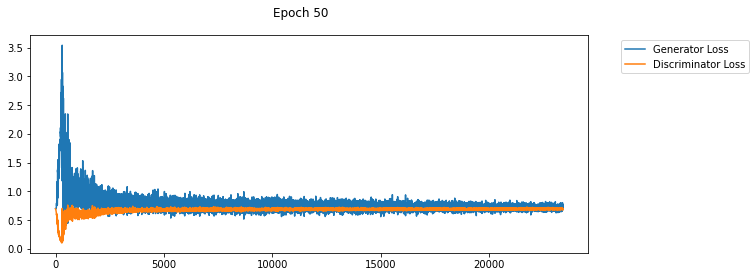

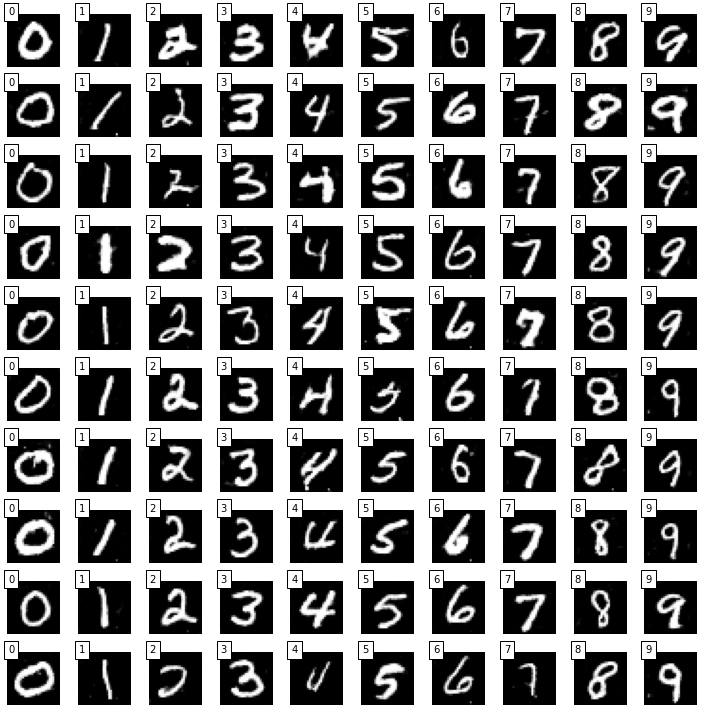

In [8]:
loss = {'generator': [], 'discriminator': []}

for epoch in range(1, 51):
  for batch in range(batches_in_epoch):
    data = next(data_gen)

    batch_loss, vars_g, vars_d, optim_g, optim_d, key = train_step(
        data, vars_g, vars_d, optim_g, optim_d, key
    )

    loss['generator'].append(batch_loss['generator'])
    loss['discriminator'].append(batch_loss['discriminator'])
   
  sample = eval_step(optim_g.target, vars_g, latent)
  plot(sample, loss, labels, epoch)